In [1]:
cd ~/3TDisk/Experiments/2D-TAN/

/mnt/sda/otani/Experiments/2D-TAN


In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append("./lib")

import os
import math
import argparse
import pickle as pkl

from tqdm import tqdm
import numpy as np
import torch
from torch.utils.data import DataLoader

# import _init_paths
from core.engine import Engine
import datasets
import models
from core.utils import AverageMeter
from core.config import config, update_config
from core.eval import eval_predictions, display_results
import models.loss as loss

In [7]:
ls ./checkpoints/ActivityNet/

iter005845-0.5945-0.8744.pkl  iter009352-0.5875-0.8565.pkl


In [3]:
update_config("experiments/activitynet/2D-TAN-64x64-K9L4-conv.yaml")
test_dataset = datasets.ActivityNet("test")

In [5]:
config.MODEL.CHECKPOINT

'./checkpoints/ActivityNet/iter009352-0.5875-0.8565.pkl'

In [4]:
model = models.TAN()
model_checkpoint = torch.load(config.MODEL.CHECKPOINT)
model.load_state_dict(model_checkpoint)
model.eval()

TAN(
  (frame_layer): FrameAvgPool(
    (vis_conv): Conv1d(500, 512, kernel_size=(1,), stride=(1,))
    (avg_pool): AvgPool1d(kernel_size=(4,), stride=(4,), padding=(0,))
  )
  (prop_layer): SparsePropConv(
    (layers): ModuleList(
      (0): ModuleList(
        (0): Conv1d(512, 512, kernel_size=(1,), stride=(1,))
        (1): Conv1d(512, 512, kernel_size=(2,), stride=(1,))
        (2): Conv1d(512, 512, kernel_size=(2,), stride=(1,))
        (3): Conv1d(512, 512, kernel_size=(2,), stride=(1,))
        (4): Conv1d(512, 512, kernel_size=(2,), stride=(1,))
        (5): Conv1d(512, 512, kernel_size=(2,), stride=(1,))
        (6): Conv1d(512, 512, kernel_size=(2,), stride=(1,))
        (7): Conv1d(512, 512, kernel_size=(2,), stride=(1,))
        (8): Conv1d(512, 512, kernel_size=(2,), stride=(1,))
        (9): Conv1d(512, 512, kernel_size=(2,), stride=(1,))
        (10): Conv1d(512, 512, kernel_size=(2,), stride=(1,))
        (11): Conv1d(512, 512, kernel_size=(2,), stride=(1,))
        (1

In [8]:
dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=config.WORKERS,
    pin_memory=False,
    collate_fn=datasets.collate_fn,
)

In [9]:
data_iter = iter(dataloader)
sample = data_iter.next()

In [10]:
def prediction(textual_input, visual_input, textual_mask, map_gt):
    prediction, map_mask = model(textual_input, textual_mask, visual_input)
    _, joint_prob = getattr(loss, config.LOSS.NAME)(
        prediction, map_mask, map_gt, config.LOSS.PARAMS
    )
    return joint_prob[0,:,:,:]

In [11]:
textual_input = sample["batch_word_vectors"]
textual_mask = sample["batch_txt_mask"]
visual_input = sample["batch_vis_input"]
map_gt = sample["batch_map_gt"]

output = prediction(textual_input, visual_input, textual_mask, map_gt)

In [13]:
from captum.attr import IntegratedGradients

# sample = data_iter.next()

ig = IntegratedGradients(prediction)

textual_input = sample["batch_word_vectors"]
textual_mask = sample["batch_txt_mask"]
visual_input = sample["batch_vis_input"]
map_gt = sample["batch_map_gt"]

baseline_a = (torch.rand_like(textual_input) - 0.5) * 2 * textual_input.max().abs()
baseline_b = (torch.rand_like(visual_input) - 0.5) * 2 * textual_input.max().abs()

attributions, approximation_error = ig.attribute((textual_input, visual_input),
                                                 baselines=(baseline_a, baseline_b),
                                                 target=(0, 59),
                                                 method='gausslegendre',
                                                 return_convergence_delta=True,
                                                 additional_forward_args=(textual_mask, map_gt)
                                                )

In [ ]:
_, axes = plt.subplots(1, 3, figsize=(20, 3))
axes[0].matshow(sample["batch_vis_input"][-1][:, :].numpy())
axes[0].set_ylabel('time',fontsize=18)
axes[1].matshow(shuffle_sample["batch_vis_input"][-1][:, :].numpy())
axes[2].matshow(random_sample["batch_vis_input"][-1][:, :].numpy())

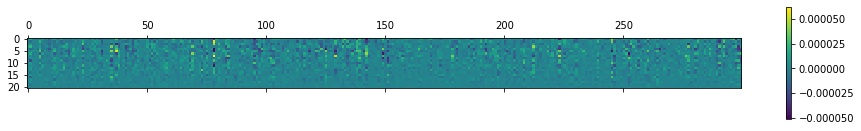

In [16]:
plt.matshow(attributions[0].squeeze().numpy())
plt.colorbar()

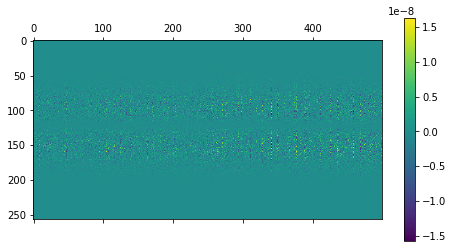

In [18]:
plt.matshow(attributions[1].squeeze().numpy())
plt.colorbar()

In [27]:
print(f"{np.abs(attributions[0].squeeze().numpy()).max():.8f}")
print(f"{np.abs(attributions[1].squeeze().numpy()).max():.8f}")

0.00006222
0.00000002
